Analysis of Modules

Imports and initial definitions

In [2]:
%matplotlib inline
# %matplotlib notebook

from __future__ import division, print_function

import os
import scipy.io.arff as arff
import numpy as np
import matplotlib.pyplot as plt
import pydotplus
from matplotlib import gridspec
from cycler import cycler
from sklearn import tree
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score
from scipy.stats.stats import pearsonr
from IPython.display import Image
from itertools import product

# os.chdir('/media/Data/Research Data/Evolving ES data/')
os.chdir('C:\\Users\\Sander\\surfdrive\\Research Data\\Evolving the Structure of Evolution Strategies\\experiments\\BF runs')
np.set_printoptions(precision=4, linewidth=200)
plt.rc('axes', prop_cycle=(cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', 
                                            '#d62728', '#9467bd', '#8c564b', 
                                            '#e377c2', '#7f7f7f', '#bcbd22', 
                                            '#1f77b4', '#ff7f0e']) +
                           cycler('linestyle', ['-', '-', '-', 
                                                '-', '-', '-', 
                                                '-', '-', '-', 
                                                '--', '--'])))

fname = 'bruteforce_{}_f{}.arff'
dims = [2, 3, 5, 10, 20]
fids = range(1, 25)
indices = product(dims, fids)
modules = ['Active', 'Elitist', 'Mirrored', 'Orthogonal', 'Sequential', 'Threshold', 'TPA', 'Selection', 'Weights', 'Base-Sampler', '(B)IPOP']


cases = {dim: {} for dim in dims}

for dim in dims:
    for fid in fids:
        case = arff.loadarff('arff/' + fname.format(dim, fid))[0]
        case = np.array([list(dat) for dat in case])
        cases[dim][fid] = case

In [3]:
min_column = [0] * 2304
min_column.extend(range(1,2305))
min_column = np.array(min_column).reshape((4608,1))

max_column = range(1, 2305)
max_column.extend([2304] * 2304)
max_column = np.array(max_column).reshape((4608,1))

min_columns = np.repeat(min_column, 9, axis=1)
max_columns = np.repeat(max_column, 9, axis=1)


min_column = [0] * 1536
min_column.extend(range(1,3073))
min_column = np.array(min_column).reshape((4608,1))

max_column = range(1, 3073)
max_column.extend([3072] * 1536)
max_column = np.array(max_column).reshape((4608,1))

min_columns = np.hstack((min_columns, min_column, min_column))
max_columns = np.hstack((max_columns, max_column, max_column))

dists = max_columns - min_columns
dists[-1,:] = 1

Example plots for the scaled cumsum/count plots

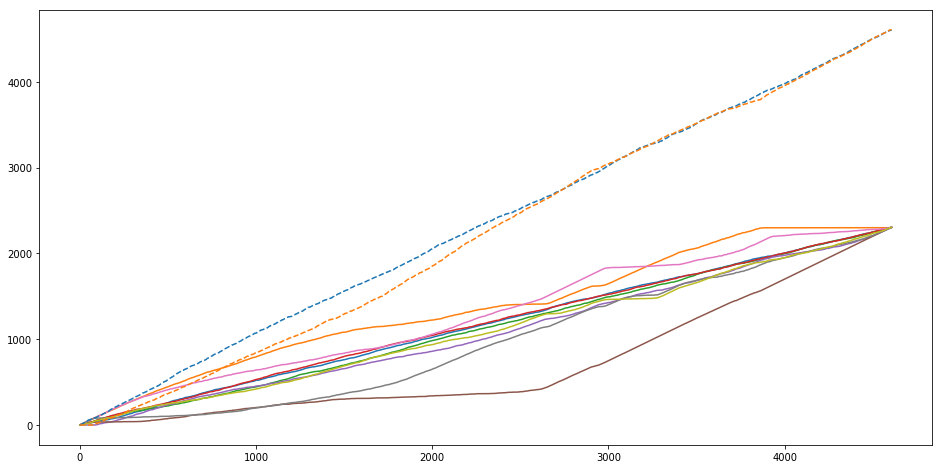

In [4]:
plt.figure(figsize=(16, 8))
plt.plot(np.cumsum(cases[2][1][cases[2][1][:,11].argsort()][:,:11], axis=0))
plt.show()

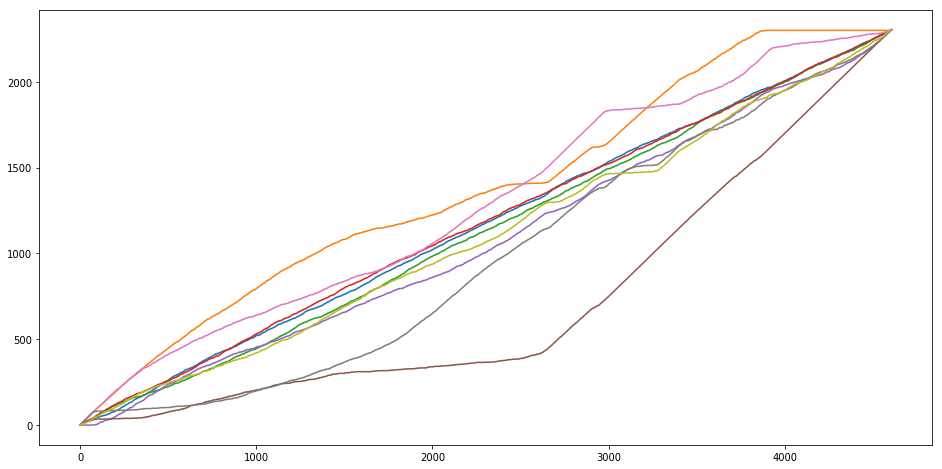

In [5]:
plt.figure(figsize=(16, 8))
plt.plot(np.cumsum(cases[2][1][cases[2][1][:,11].argsort()][:,:9], axis=0))
plt.show()

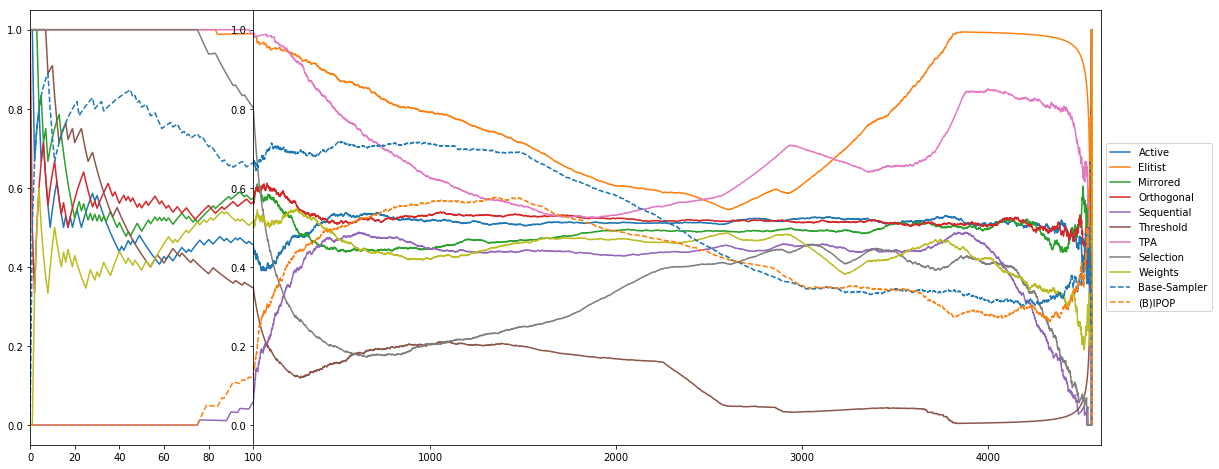

In [10]:
temp = cases[2][1][ cases[2][1][:,11].argsort() ][:,:11]

# replace all values '2' with '1'
two_indices = temp == 2
temp[two_indices] = 1

temp = np.cumsum(temp, axis=0)
temp = temp - min_columns
temp = temp / dists

labels = modules

cutoff = 100

plt.figure(figsize=(20, 8))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 4]) 

ax1 = plt.subplot(gs[0])
ax1.plot(temp[:cutoff+1,:])
# ax1.plot([.5]*4608, 'k')
ax1.set_xlim([0, cutoff])

ax2 = plt.subplot(gs[1], sharey=ax1)
lines = ax2.plot(temp[cutoff//2:,:])
# ax2.plot([.5]*4608, 'k')
ax2.set_xlim([cutoff//2,4608])

plt.subplots_adjust(wspace=0, hspace=0)

# Shrink current axis by 20%
box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width * 0.95, box.height])

# Put a legend to the right of the current axis
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), handles=lines, labels=labels)

plt.show()

Create and store scaled cumsum/count plots

In [23]:
labels = modules

for dim in dims:
    for fid in fids:
        temp = cases[dim][fid][ cases[dim][fid][:,11].argsort() ][:,:11]

        # replace all values '2' with '1'
        two_indices = temp == 2
        temp[two_indices] = 1

        temp = np.cumsum(temp, axis=0)
        temp = temp - min_columns
        temp = temp / dists
        
        cutoff = 100
        
        plt.figure(figsize=(20, 8))
        plt.suptitle("Progression for {}D F{}".format(dim, fid))
        gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
        
        ax1 = plt.subplot(gs[0])
        ax1.plot(temp[:cutoff+1,:])
        ax1.set_xlim([0, cutoff])
        
        ax2 = plt.subplot(gs[1], sharey=ax1)
        lines = ax2.plot(temp[cutoff//2:,:])
        ax2.set_xlim([cutoff//2,4608])

        plt.tight_layout()
        
        plt.subplots_adjust(wspace=0, hspace=0, top=0.88)

        # Shrink current axis by 15%
        box = ax2.get_position()
        ax2.set_position([box.x0, box.y0, box.width * 0.85, box.height])
        
        # Put a legend to the right of the current axis
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), handles=lines, labels=labels)
        
        plt.savefig("plots/module_progression_{}_f{}.png".format(dim, fid))
        # plt.savefig("plots/module_progression_{}_f{}.pdf".format(dim, fid))
        
        plt.close()

Plot the combined ERT/FCE measure

All dimensionalities per function in a single plot

In [25]:
for fid in fids:
    plt.figure(figsize=(16, 8))
    plt.title("(ERT, FCE) -> [0, 2] vs ranking for F{} in 2, 3, 5, 10 and 20D".format(fid))
    
    for dim in dims:
        temp = cases[dim][fid][ cases[dim][fid][:,11].argsort() ][:,11]
        plt.plot(temp, label=dim)

    plt.plot([1]*temp.shape[0], 'k')
    plt.legend(loc=0)
    plt.tight_layout()
    plt.ylim([0,2])
    plt.xlim([0,4608])
            
    plt.savefig("plots/ERT_FCE_f{}.png".format(fid))
    # plt.savefig("plots/ERT_FCE_f{}.pdf".format(fid))
    
    plt.close()

Plot number of active modules

In [26]:
import gc

for dim in dims:
    for fid in fids:
        temp = np.count_nonzero(cases[dim][fid][ cases[dim][fid][:,11].argsort() ][:,:11], axis=1)

        plt.figure(figsize=(16, 8))
        plt.title("Number of active modules vs ranking for {}D F{}".format(dim, fid))
        
        plt.plot(temp, '.')
        plt.tight_layout()
                
        plt.savefig("plots/num_active_modules_{}_f{}.png".format(dim, fid))
        # plt.savefig("plots/num_active_modules_{}_f{}.pdf".format(dim, fid))
        
        plt.clf()
        plt.close()
        del temp
        gc.collect()

Decision Trees

Full size trees

In [12]:
features = modules

for dim in dims:
    for fid in fids:
        clf = tree.DecisionTreeRegressor(min_samples_split=50, min_samples_leaf=20)
        clf = clf.fit(cases[dim][fid][:,:11], cases[dim][fid][:,11])
        
        dot_data = tree.export_graphviz(clf, out_file=None,
                                        feature_names=features,
                                        class_names=['Fitness'],
                                        filled=True,
                                        rounded=True,
                                        )
        graph = pydotplus.graph_from_dot_data(dot_data)  
        graph.write_png("plots/regressor_tree_{}_f{}.png".format(dim, fid))
        # graph.write_pdf("plots/regressor_tree_{}_f{}.pdf".format(dim, fid))

Small trees

In [13]:
features = modules

for dim in dims:
    for fid in fids:
        clf = tree.DecisionTreeRegressor(max_depth=4, min_samples_split=50, min_samples_leaf=20)
        clf = clf.fit(cases[dim][fid][:,:11], cases[dim][fid][:,11])
        
        dot_data = tree.export_graphviz(clf, out_file=None,
                                        feature_names=features,
                                        class_names=['Fitness'],
                                        filled=True,
                                        rounded=True,
                                        )
        graph = pydotplus.graph_from_dot_data(dot_data)
        graph.write_png("plots/small_regressor_tree_{}_f{}.png".format(dim, fid))
        # graph.write_pdf("plots/small_regressor_tree_{}_f{}.pdf".format(dim, fid))

In [14]:
features = modules

best_x = 250

for dim in dims:
    for fid in fids:
        clf = tree.DecisionTreeRegressor(min_samples_split=20, min_samples_leaf=10)
        clf = clf.fit(cases[dim][fid][:best_x,:11], cases[dim][fid][:best_x,11])
        
        dot_data = tree.export_graphviz(clf, out_file=None,
                                        feature_names=features,
                                        class_names=['Fitness'],
                                        filled=True,
                                        rounded=True,
                                        )
        graph = pydotplus.graph_from_dot_data(dot_data)
        graph.write_png("plots/best_{}_regressor_tree_{}_f{}.png".format(best_x, dim, fid))
        # graph.write_pdf("plots/best_{}_regressor_tree_{}_f{}.pdf".format(best_x, dim, fid))

Statistics

In [11]:
scores = {dim: np.zeros(len(fids)) for dim in dims}
np.set_printoptions(precision=2, linewidth=200)

for dim in dims:
    for fid in fids:
        clf = tree.DecisionTreeRegressor(min_samples_split=50, min_samples_leaf=20)
        clf = clf.fit(cases[dim][fid][:,:11], cases[dim][fid][:,11])
        scores[dim][fid-1] = np.mean(cross_val_score(clf, cases[dim][fid][:,:11], cases[dim][fid][:,11], cv=20))

print(" 2:", scores[2])
print(" 3:", scores[3])
print(" 5:", scores[5])
print("10:", scores[10])
print("20:", scores[20])

 2: [ 0.65  0.91  0.81  0.45  0.9   0.95  0.61  0.91  0.91  0.92  0.92  0.92  0.93  0.91  0.83  0.85  0.87  0.81  0.88  0.74  0.8   0.91  0.87  0.37]
 3: [ 0.45  0.94  0.61  0.16  0.98  0.92  0.81  0.93  0.92  0.93  0.92  0.95  0.91  0.94  0.66  0.8   0.8   0.65  0.33  0.4   0.89  0.92  0.63  0.4 ]
 5: [ 0.79  0.87  0.22  0.52  0.92  0.78  0.84  0.79  0.8   0.83  0.82  0.86  0.84  0.84  0.32  0.56  0.63  0.47  0.51 -0.02  0.46  0.56  0.12  0.89]
10: [ 0.82  0.6   0.68  0.84  0.84  0.61  0.78  0.74  0.76  0.51 -0.6   0.82  0.42  0.86  0.63  0.64  0.7   0.77  0.85  0.83  0.71  0.49  0.8   0.84]
20: [ 0.87  0.8   0.67  0.69  0.85  0.58  0.64  0.69  0.74  0.77  0.1   0.83  0.73  0.83  0.68  0.89  0.74  0.78  0.8  -2.57  0.76  0.25  0.84  0.82]


In [12]:
correlations = np.zeros((120, 120, 11))  # (module, from, to)
data = []
indices = product(dims, fids)

for count, index in enumerate(indices):
    dim, fid = index
    temp = cases[dim][fid][ cases[dim][fid][:,11].argsort() ][:,:11]

    # replace all values '2' with '1'
    two_indices = temp == 2
    temp[two_indices] = 1

    temp = np.cumsum(temp, axis=0)
    temp = temp - min_columns
    temp = temp / dists
    
    data.append(temp)
    
    for i in range(count+1):
        for mod in range(11):
            correlations[i, count, mod] = pearsonr(temp[:, mod], data[i][:, mod])[0]
            correlations[count, i, mod] = correlations[i, count, mod]  # Symmetry!

In [13]:
for mod in range(11):
    np.savetxt("csv/module{}.csv".format(mod), correlations[:,:,mod], delimiter=",")

In [16]:
x = np.arange(120)
y = np.arange(120)
X, Y = np.meshgrid(x, y)

for mod in range(11):
    plt.figure(figsize=(16,8))
    plt.pcolor(X, Y, correlations[:,:,mod], cmap='viridis', vmin=-1, vmax=1)
    plt.title("Behavior correlation for module '{}'".format(modules[mod]))
    plt.colorbar(label='Correlation')
    plt.savefig("plots/correlation_heatmap_{}.png".format(modules[mod]))
    # plt.savefig("plots/correlation_heatmap_{}.pdf".format(features[mod]))
    plt.close()

In [15]:
importances = np.zeros((len(dims), len(fids), len(modules)))

for i_dim, dim in enumerate(dims):
    for fid in fids:
        forest = ExtraTreesRegressor(n_estimators=250, min_samples_split=50, min_samples_leaf=20)
        forest = forest.fit(cases[dim][fid][:,:11], cases[dim][fid][:,11])

        importance = forest.feature_importances_
        importances[i_dim,fid-1,:] = importance

In [17]:
feature_importances = np.mean(np.mean(importances, axis=0), axis=0)
feature_indices = np.argsort(feature_importances)[::-1]
print(feature_importances)

# Print the feature ranking
print("Feature ranking:")

for f in range(len(feature_indices)):
    print("{}. feature {} ({})".format(f + 1, modules[feature_indices[f]], feature_importances[feature_indices[f]]))

[ 0.07  0.23  0.01  0.01  0.03  0.31  0.14  0.07  0.05  0.02  0.06]
Feature ranking:
1. feature Threshold (0.311302572314)
2. feature Elitist (0.22771163352)
3. feature TPA (0.138024895285)
4. feature Selection (0.0678977281862)
5. feature Active (0.0654170085417)
6. feature (B)IPOP (0.0643239445451)
7. feature Weights (0.0539134896353)
8. feature Sequential (0.032855785757)
9. feature Base-Sampler (0.0207561304789)
10. feature Mirrored (0.0103908577858)
11. feature Orthogonal (0.00740595395071)


Attempt at creating an impact score per module:<br>
Calculate average fitness for when a module is on and off, then subtract 'on' from 'off'.<br>
If the a module has a positive impact, it will have a positive impact score

In [12]:
impact = np.zeros((len(dims), len(fids), len(modules)))

for i_dim, dim in enumerate(dims):
    for fid in fids:
        temp = cases[dim][fid]
        
        for mod in range(len(modules)):
            indices_on = temp[:,mod] > 0
            indices_off = temp[:,mod] < 1
            
            mean_on = np.mean(temp[indices_on,11])
            mean_off = np.mean(temp[indices_off,11])
            impact[i_dim, fid-1, mod] = mean_off - mean_on
            

for x in zip(np.mean(np.mean(impact, axis=0), axis=0), modules):
    print(x)

(-0.12603970584977009, 'Active')
(0.27416365303545787, 'Elitist')
(0.011357664679502499, 'Mirrored')
(0.022634543826004504, 'Orthogonal')
(-0.10255795951440454, 'Sequential')
(-0.49105428278396746, 'Threshold')
(0.070425108657990204, 'TPA')
(-0.027580828001063332, 'Selection')
(-0.12167295200649131, 'Weights')
(0.01757243050122834, 'Base-Sampler')
(0.10384405460922863, '(B)IPOP')


In [19]:
x = np.arange(len(fids)+1)
y = np.arange(len(dims)+1)
X, Y = np.meshgrid(x, y)

minval = np.min(impact)
maxval = np.max(impact)


for mod in range(len(modules)):
    plt.figure(figsize=(6,3))
    plt.pcolor(X, Y, impact[:,:,mod], cmap='viridis', vmin=minval, vmax=maxval)
    plt.title("Impact of {} module".format(modules[mod]))
    plt.colorbar(label='Impact')
    plt.xlim([0,24])
    plt.ylabel("Dimension")
    plt.yticks([.5, 1.5, 2.5, 3.5, 4.5], ['2', '3', '5', '10', '20'])
    plt.xticks(np.arange(len(fids))+.5, np.arange(len(fids))+1)
    plt.xlabel("Function")
    plt.tight_layout()
    plt.savefig("plots/impact_heatmap_{}.png".format(modules[mod]))
    plt.savefig("plots/impact_heatmap_{}.pdf".format(modules[mod]))
    plt.close()

-1.25016088099 0.853054811624


In [23]:
### TODO ###
# Improve this approach using
# https://stackoverflow.com/questions/13784201/matplotlib-2-subplots-1-colorbar
### END-TODO ###

x = np.arange(len(fids)+1)
y = np.arange(len(dims)+1)
X, Y = np.meshgrid(x, y)

minval = np.min(impact)
maxval = np.max(impact)

plt.figure(figsize=(6,9))
for subplot, mod in enumerate([5, 10, 1]):  # Threshold, (B)IPOP and Elitist
    plt.subplot(3, 1, subplot+1)
    plt.pcolor(X, Y, impact[:,:,mod], cmap='viridis', vmin=minval, vmax=maxval)
    plt.title("Impact of {} module".format(modules[mod]))
    plt.xlim([0,24])
    plt.ylabel("Dimension")
    plt.yticks([.5, 1.5, 2.5, 3.5, 4.5], ['2', '3', '5', '10', '20'])
    plt.xticks(np.arange(len(fids))+.5, np.arange(len(fids))+1)
    plt.xlabel("Function")

plt.colorbar(label='Impact')
plt.tight_layout()
plt.savefig("plots/impact_heatmap.png")
plt.savefig("plots/impact_heatmap.pdf")
plt.close()

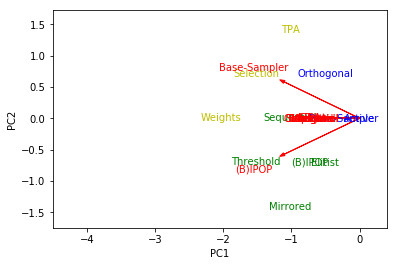

In [16]:
from scipy.cluster.vq import kmeans, vq
from statsmodels.sandbox.tools.tools_pca import pcasvd


def biplot(plt, pca, labels=None, colors=None,
           xpc=1, ypc=2, scale=1):
    """Generate biplot from the result of pcasvd of statsmodels.
    Parameters
    ----------
    plt : object
        An existing pyplot module reference.
    pca : tuple
        The result from statsmodels.sandbox.tools.tools_pca.pcasvd.
    labels : array_like, optional
        Labels for each observation.
    colors : array_like, optional
        Colors for each observation.
    xpc, ypc : int, optional
        The principal component number for x- and y-axis. Defaults to
        (xpc, ypc) = (1, 2).
    scale : float
        The variables are scaled by lambda ** scale, where lambda =
        singular value = sqrt(eigenvalue), and the observations are
        scaled by lambda ** (1 - scale). Must be in [0, 1].
    Returns
    -------
    None.
    """
    xpc, ypc = (xpc - 1, ypc - 1)
    xreduced, factors, evals, evecs = pca
    singvals = np.sqrt(evals)

    # data
    xs = factors[:, xpc] * singvals[xpc]**(1. - scale)
    ys = factors[:, ypc] * singvals[ypc]**(1. - scale)

    if labels is not None:
        for i, (t, x, y) in enumerate(zip(labels, xs, ys)):
            c = 'k' if colors is None else colors[i]
            plt.text(x, y, t, color=c, ha='center', va='center')
        xmin, xmax = xs.min(), xs.max()
        ymin, ymax = ys.min(), ys.max()
        xpad = (xmax - xmin) * 0.1
        ypad = (ymax - ymin) * 0.1
        plt.xlim(xmin - xpad, xmax + xpad)
        plt.ylim(ymin - ypad, ymax + ypad)
    else:
        colors = 'k' if colors is None else colors
        plt.scatter(xs, ys, c=colors, marker='.')

    # variables
    tvars = np.dot(np.eye(factors.shape[0], factors.shape[1]),
                   evecs) * singvals**scale

    for i, col in enumerate(modules):  # enumerate(xreduced.columns.values):
        x, y = tvars[i][xpc], tvars[i][ypc]
        plt.arrow(0, 0, x, y, color='r',
                  width=0.002, head_width=0.05)
        plt.text(x* 1.4, y * 1.4, col, color='r', ha='center', va='center')

    plt.xlabel('PC{}'.format(xpc + 1))
    plt.ylabel('PC{}'.format(ypc + 1))

    
pca = pcasvd(cases[2][1], keepdim=0, demean=False)

values = cases[2][1]
centroids, _ = kmeans(values, 3)
idx, _ = vq(values, centroids)

colors = ['gby'[i] for i in idx]

plt.figure(1)
biplot(plt, pca, labels=modules, colors=colors,
       xpc=1, ypc=2)
plt.show()